In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

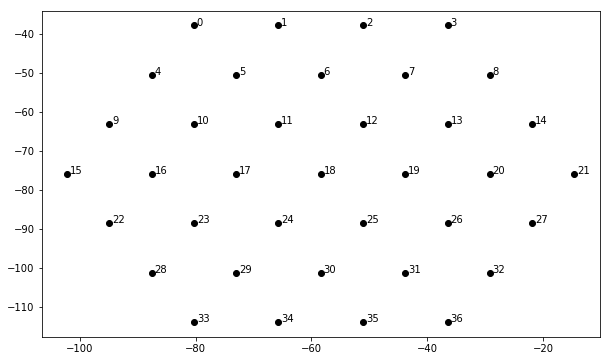

In [3]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))
plot_ants(antpos)

In [4]:
def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

In [5]:
len(redbls[0])

30

# Minimal inclusion

List of redundant baselines where every antenna is used only once.

**Minimal inclusion will not work because the number of cross correlations you compute is less that the number of equations you need to solve for any redundant pair you consider. **

In [6]:
def ant_in_bls(ant,baselines):
    bl = np.asarray([list(x) for x in baselines])
    if not np.size(bl):
        return False
    if ant in bl[:,0] or ant in bl[:,1]:
        return True
    else: return False
    
def build_minimal_cc(redbl_list):
    minimal_bl = []

    for i,j in redbl_list:
        if ant_in_bls(i,minimal_bl):
            continue
        if ant_in_bls(j,minimal_bl):
            continue
        else: minimal_bl.append((i,j))

    for i,j in redbl_list:
        if not ant_in_bls(i,minimal_bl) or not ant_in_bls(j,minimal_bl):
            minimal_bl.append((i,j))
            
    return minimal_bl

[(5, 0), (6, 1), (7, 2), (8, 3), (10, 4), (16, 9), (18, 11), (19, 12), (20, 13), (21, 14), (22, 15), (24, 17), (29, 23), (31, 25), (32, 26), (33, 28), (35, 30), (27, 20), (34, 29), (36, 31)]


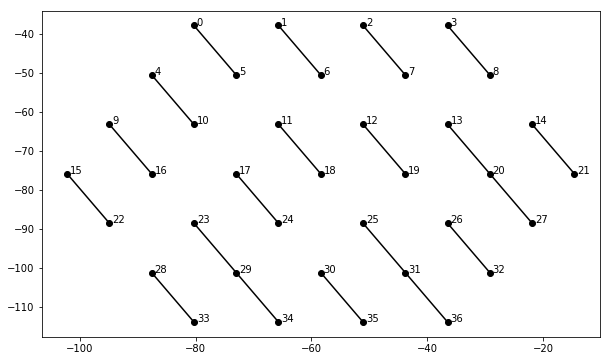

In [7]:
minbl = build_minimal_cc(redbls[0])
plot_redbl(minbl)
plot_ants(antpos)
print minbl

# Minimal unit

The smallest repeating unit that has redundant baselines with number of measurements greater than number of equation is the 7 antenna hexagon.

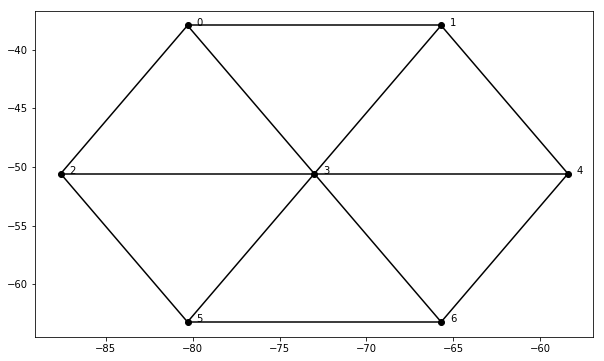

In [10]:
Nants = 7
ants = np.loadtxt('antenna_positions_37.dat')
idxs = np.arange(Nants)
antpos = {}

antpos[0] = ants[0]; antpos[1] = ants[1]
antpos[2] = ants[4]; antpos[3] = ants[5]; antpos[4] = ants[6]
antpos[5] = ants[10]; antpos[6] = ants[11]

plot_ants(antpos)

redbls = hera_cal.redcal.get_pos_reds(antpos)
plot_redbl(redbls[0])
plot_redbl(redbls[1])
plot_redbl(redbls[2])

In [11]:
def genA(redbls):
    # number of measurements = total number of baselines
    M = 0
    for i in range(len(redbls)):
        M += len(redbls[i])
    
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = 1+1j
            A[i,pair[1]] = 1-1j
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [12]:
A = genA(redbls)
print np.shape(A)

(21, 16)


In [13]:
np.linalg.matrix_rank(A)

15

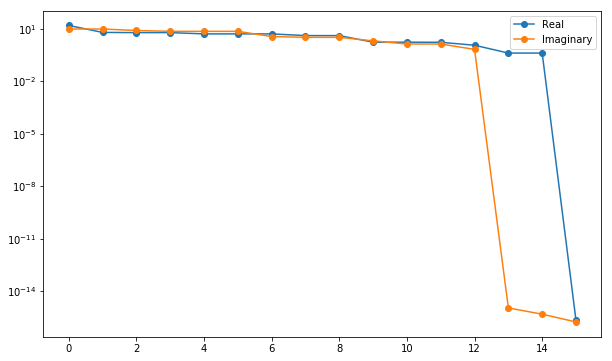

In [11]:
Mr = np.dot(np.real(A).T, np.real(A))
Mi = np.dot(np.imag(A).T, np.imag(A))

Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

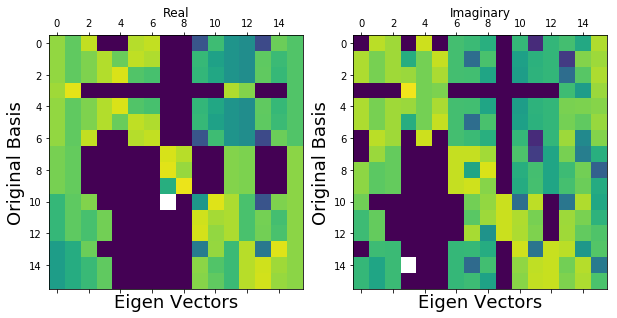

In [12]:
import warnings
warnings.filterwarnings('ignore')

fig,ax = plt.subplots(1,2)

im = ax[0].matshow(np.log10(np.abs(Ur)),vmax=0,vmin=-3,cmap='viridis')
ax[0].set_title('Real')
ax[0].set_xlabel('Eigen Vectors',fontsize=18)
ax[0].set_ylabel('Original Basis',fontsize=18)

im = ax[1].matshow(np.log10(np.abs(Ui)),vmax=0,vmin=-3,cmap='viridis')
ax[1].set_title('Imaginary')
ax[1].set_xlabel('Eigen Vectors',fontsize=18)
ax[1].set_ylabel('Original Basis',fontsize=18)

# Integration time

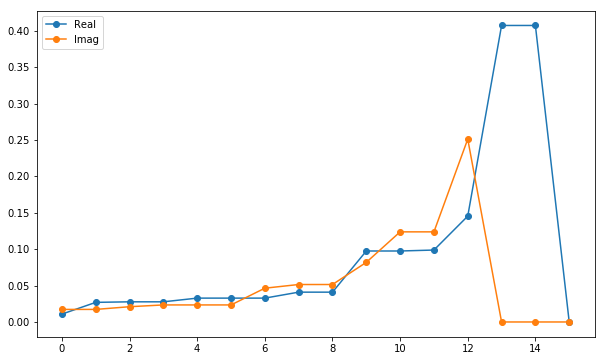

In [14]:
Tsys = 500
Tsrc = 5
B = 250e6/4096

Sr_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Sr])
Si_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Si])

tr = Tsys**2/(B*Tsrc**2)*Sr_inv
ti = Tsys**2/(B*Tsrc**2)*Si_inv

plt.plot(tr,'o-',label='Real')
plt.plot(ti,'o-',label='Imag')
plt.legend()
plt.show()

In [15]:
pi_s_real = np.asarray([1 if s>10**-11 else 0 for s in Sr])
pi_s_imag = np.asarray([1 if s>10**-11 else 0 for s in Si])

In [16]:
Pr = np.einsum('nm,m,mp->np',Ur,pi_s_real,Vr)
Pi = np.einsum('nm,m,mp->np',Ui,pi_s_imag,Vi)

In [17]:
for i,j in zip(Mr, Pr):
    print np.round(i,decimals=2)
    print np.round(j,decimals=2)

[[ 6.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.]]
[ 0.98 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05]
[[ 1.  6.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.]]
[-0.02  0.98 -0.02 -0.02 -0.02 -0.02 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05]
[[ 1.  1.  6.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.]]
[-0.02 -0.02  0.98 -0.02 -0.02 -0.02 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05]
[[ 1.  1.  1.  6.  1.  1.  1.  2.  2.  2.  0.  0.  0.  0.  0.  0.]]
[-0.02 -0.02 -0.02  0.98 -0.02 -0.02 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05]
[[ 1.  1.  1.  1.  6.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.]]
[-0.02 -0.02 -0.02 -0.02  0.98 -0.02 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05]
[[ 1.  1.  1.  1.  1.  6.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.]]
[-0.02 -0.02 -0.02 -0.02 -0.02  0.98 -0.02  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05

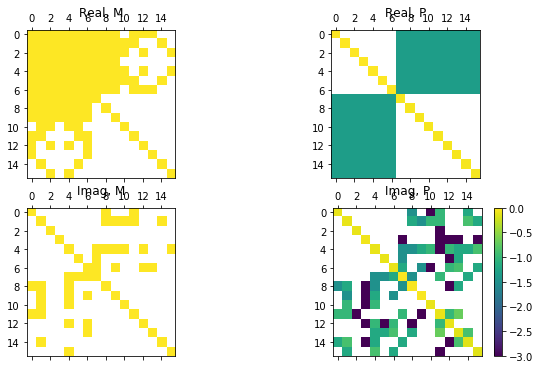

In [18]:
import warnings
warnings.filterwarnings('ignore')

fig,ax = plt.subplots(2,2)

im= ax[0][0].matshow(np.log10(Mr),vmax=0,vmin=-3,cmap='viridis')
ax[0][0].set_title('Real, M')
im= ax[0][1].matshow(np.log10(Pr),vmax=0,vmin=-3,cmap='viridis')
ax[0][1].set_title('Real, P')

im= ax[1][0].matshow(np.log10(Mi),vmax=0,vmin=-3,cmap='viridis')
ax[1][0].set_title('Imag, M')
im= ax[1][1].matshow(np.log10(Pi),vmax=0,vmin=-3,cmap='viridis')
ax[1][1].set_title('Imag, P')
fig.colorbar(im)